In [ ]:
!pip install transformers==3

In [ ]:
!pip install opacus

In [ ]:
# Importing libraries
import pandas as pd
import torch
import torch.nn as nn
import transformers
from torch.utils.data import Dataset, DataLoader
# Optimizer from hugging face transformers
from transformers import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import time
import opacus
from opacus import PrivacyEngine 
import copy
import os
import logging
logging.basicConfig(level=logging.ERROR)

In [ ]:
# Setting up GPU
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/dep1_cleaned.csv')
df.head()

,Unnamed: 0,tweet,target
0,0,Today in Selfcare: beauty ; laughs Kung Fu Pan...,0
1,1,I get to spend New Year's home again alone and...,1
2,2,"Depressed and lonely /: Stuck in a deep, never...",1
3,3,If this is your response to someone saying the...,0
4,4,Apparently you get a free pass just by mention...,0


##Partitioning

###IID

In [ ]:
def iid_partition(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

###Non-IID

In [ ]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Each of the clients will get X shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between
    - total_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard 
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives

  returns:
    - Dictionary of image indexes for each client
  """
  
  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  idxs = np.arange(len(dataset))
  data_labels = dataset.get_labels()

  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  idxs = label_idxs[0,:]

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    shard_idxs = list(set(shard_idxs) - rand_set)

    for rand in rand_set:
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
  
  return client_dict

# MAIN

## MODELS

In [ ]:
# Importing BERT-base pretrained model
bert = AutoModel.from_pretrained('albert-base-v2')
# Load the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('albert-base-v2')

In [ ]:
# Model Architecture

class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # Dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # Relu activation function
      self.relu =  nn.ReLU()

      # Dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # Dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      # Softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    # Define the forward pass
    def forward(self, sent_id, mask):

      # Pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # Output layer
      x = self.fc2(x)
      
      # Apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# Pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# Push the model to GPU
model = model.to(device)
model

BERT_Arch(
  (bert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
            

In [ ]:
trainable_layers = [model.fc1, model.fc2]
total_params = 0
trainable_params = 0

for p in model.parameters():
        p.requires_grad = False
        total_params += p.numel()

for layer in trainable_layers:
    for p in layer.parameters():
        p.requires_grad = True
        trainable_params += p.numel()

print(f"Total parameters count: {total_params}") # ~125M
print(f"Trainable parameters count: {trainable_params}") # ~0.5M

Total parameters count: 12078338
Trainable parameters count: 394754


In [ ]:
#Initialization
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 2
#EPOCHS = 10
LEARNING_RATE = 1e-05
#tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

In [ ]:
#The class is defined to accept the Dataframe as input and generate tokenized output that is used by the DistilBERT model for training.
#The tokenizer uses the encode_plus method to perform tokenization and generate the necessary outputs, namely: ids, attention_mask
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def get_labels(self):
        l = []
        for i in range(self.len):
          title = str(self.data.tweet[i])
          title = " ".join(title.split())
          inputs = self.tokenizer.encode_plus(
              title,
              None,
              add_special_tokens=True,
              max_length=self.max_len,
              padding='max_length',
              return_token_type_ids=True,
              truncation=True
          )

          l.append(self.data.target[i])

        return l     

        
    def __getitem__(self, index):
        title = str(self.data.tweet[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.target[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, dataset, tokenizer, max_len, idxs):
      self.data = dataset
      self.idxs = list(idxs)
      self.tokenizer = tokenizer
      self.max_len = max_len
      
  # def __init__(self, dataset, idxs):
  #     self.dataset = dataset
  #     self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, index):
      title = str(self.data.tweet[index])
      title = " ".join(title.split())
      inputs = self.tokenizer.encode_plus(
          title,
          None,
          add_special_tokens=True,
          max_length=self.max_len,
          padding='max_length',
          return_token_type_ids=True,
          truncation=True
      )
      ids = inputs['input_ids']
      mask = inputs['attention_mask']

      return {
          'ids': torch.tensor(ids, dtype=torch.long),
          'mask': torch.tensor(mask, dtype=torch.long),
          'targets': torch.tensor(self.data.target[index], dtype=torch.long)
      } 

class ClientUpdate(object):
  def __init__(self, dataset, model, tokenizer, loss_function, optimizer, idxs, epochs, MAX_LEN=256):
    self.train_loader = DataLoader(CustomDataset(dataset, tokenizer, MAX_LEN, idxs), batch_size=8, shuffle=True)
    self.model = model
    self.dataset = dataset
    self.loss_function = loss_function
    self.optimizer = optimizer
    self.epochs = epochs

  # Function to calcuate the accuracy of the model

  def calcuate_accu(self, big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

  def train(self):

    epochloss, epochacc = [], []

    for epoch in range(1, self.epochs+1):
      tr_loss = 0
      n_correct = 0
      nb_tr_steps = 0
      nb_tr_examples = 0
      losses = []
      model.train()
      for _,data in tqdm(enumerate(training_loader, 0)):
          ids = data['ids'].to(device, dtype = torch.long)
          mask = data['mask'].to(device, dtype = torch.long)
          #token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
          targets = data['targets'].to(device, dtype = torch.long)

          outputs = model(ids, mask)
          loss = loss_function(outputs, targets)
          tr_loss += loss.item()
          big_val, big_idx = torch.max(outputs.data, dim=1)
          n_correct += self.calcuate_accu(big_idx, targets)

          nb_tr_steps += 1
          nb_tr_examples+=targets.size(0)
          
          if _%2000==0:
              loss_step = tr_loss/nb_tr_steps
              accu_step = (n_correct*100)/nb_tr_examples 
              print(f"Training Loss per 5000 steps: {loss_step}")
              print(f"Training Accuracy per 5000 steps: {accu_step}")

          self.optimizer.zero_grad()
          loss.backward()
          losses.append(loss.item())
          # # When using GPU
          if (_ + 1) % 2000 == 0 or _ == len(training_loader) - 1:
              self.optimizer.step()
          else:
              self.optimizer.virtual_step()

          if _ > 0 and _ % 2000 == 0:
                train_loss = np.mean(losses)
                eps, alpha = self.optimizer.privacy_engine.get_privacy_spent(DELTA)

                eval_accuracy,eval_loss = valid(model, testing_loader)

                print(
                    f"Epoch: {epoch} | "
                    f"Step: {_} | "
                    f"Train loss: {train_loss:.3f} | "
                    f"Eval loss: {eval_loss:.3f} | "
                    f"Eval accuracy: {eval_accuracy:.3f} | "
                    f"ɛ: {eps:.2f} (α: {alpha})"
                )

          
      print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
      epoch_loss = tr_loss/nb_tr_steps
      epoch_accu = (n_correct*100)/nb_tr_examples
      print(f"Training Loss Epoch: {epoch_loss}")
      print(f"Training Accuracy Epoch: {epoch_accu}")
      epochacc.append(epoch_accu)
      epochloss.append(epoch_loss)


    return model.state_dict(), epochacc[-1], epochloss[-1]

In [ ]:
def training(model, rounds, ds, data_dict, loss_function, lr, C, K, E, plt_color):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - tb_writer_name:  Directory name to save the tensorboard logs
  Returns:
    - model:           Trained model on the server
  """

  # global model weights
  global_weights = model.state_dict()

  # training loss
  train_loss,train_acc = [], []
  
  optimizer = torch.optim.AdamW(params =  model.parameters(), lr=lr)
  
  # measure time
  start = time.time()

  LOGGING_INTERVAL = 100 # once every how many steps we run evaluation cycle and report metrics
  EPSILON = 0.5
  DELTA = 1 / len(training_set) # Parameter for privacy accounting. Probability of not achieving privacy guarantees

  SAMPLE_RATE = 8/len(ds)
  MAX_GRAD_NORM = 0.1
  VIRTUAL_BATCH_SIZE = 32
  assert VIRTUAL_BATCH_SIZE % 8 == 0 # VIRTUAL_BATCH_SIZE should be divisible by BATCH_SIZE
  N_ACCUMULATION_STEPS = int(VIRTUAL_BATCH_SIZE / 8)

  privacy_engine = PrivacyEngine(
      module=model,
      sample_rate=SAMPLE_RATE * N_ACCUMULATION_STEPS,
      target_delta = DELTA,
      target_epsilon = EPSILON, 
      epochs = E,
      max_grad_norm=MAX_GRAD_NORM,
  )

  privacy_engine.attach(optimizer)
    

  for curr_round in range(1, rounds+1):
    w, local_loss,local_acc = [], [], []

    m = max(int(C*K), 1)
    
    S_t = np.random.choice(range(K), m, replace=False)
    for k in S_t:
      local_update = ClientUpdate(dataset=ds, model=model, tokenizer=tokenizer, loss_function=loss_function, \
                                  optimizer=optimizer, epochs=E, idxs=data_dict[k])
      weights, acc, loss = local_update.train()

      w.append(copy.deepcopy(weights))
      local_loss.append(copy.deepcopy(loss))
      local_acc.append(copy.deepcopy(acc))

    # updating the global weights
    weights_avg = copy.deepcopy(w[0])
    for k in weights_avg.keys():
      for i in range(1, len(w)):
        weights_avg[k] += w[i][k]

      weights_avg[k] = torch.div(weights_avg[k], len(w))

    global_weights = weights_avg

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    acc_avg = sum(local_acc) / len(local_acc)
    print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)))
    print('Round: {}... \tAverage Accuracy: {}'.format(curr_round, round(acc_avg, 3)))
    train_loss.append(loss_avg)
    train_acc.append(acc_avg)

  end = time.time()
  
  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  # y_axis = np.array(train_loss)
  # ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  # ax.set(xlabel='Number of Rounds', ylabel='Train Loss',
  #      title="Training Loss")
  
  y_axis = np.array(train_acc)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Train Accuracy',
       title="Training Accuracy vs. Global rounds")
  ax.grid()
  #fig.savefig(plt_title+'.jpg', format='jpg')
  print("Training Done!")
  print("Total time taken to Train: {}".format(end-start))
  
  return model, train_acc

In [ ]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8
train_dataset=df.sample(frac=train_size,random_state=200)
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = Triage(train_dataset, tokenizer, MAX_LEN)
testing_set = Triage(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (3096, 3)
TRAIN Dataset: (2477, 3)
TEST Dataset: (619, 3)


In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:523: UserWarning: A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
  "A ``sample_rate`` has been provided."
/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:195: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full b

Training Loss per 5000 steps: 0.5696076154708862
Training Accuracy per 5000 steps: 87.5


310it [01:23,  3.70it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 1: 73.15300767056924
Training Loss Epoch: 0.6129741748494487
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.77it/s]

Training Loss per 5000 steps: 0.48942476511001587
Training Accuracy per 5000 steps: 100.0


310it [01:25,  3.63it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 2: 73.15300767056924
Training Loss Epoch: 0.6127792889072049
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.78it/s]

Training Loss per 5000 steps: 0.672280490398407
Training Accuracy per 5000 steps: 62.5


310it [01:25,  3.63it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 3: 73.15300767056924
Training Loss Epoch: 0.6131264119378982
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.76it/s]

Training Loss per 5000 steps: 0.46040642261505127
Training Accuracy per 5000 steps: 100.0


310it [01:25,  3.63it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 1: 73.15300767056924
Training Loss Epoch: 0.61406719348123
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.78it/s]

Training Loss per 5000 steps: 0.594400942325592
Training Accuracy per 5000 steps: 75.0


310it [01:25,  3.63it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 2: 73.1126362535325
Training Loss Epoch: 0.6106596718872747
Training Accuracy Epoch: 73.1126362535325


1it [00:00,  3.74it/s]

Training Loss per 5000 steps: 0.5914656519889832
Training Accuracy per 5000 steps: 75.0


310it [01:25,  3.63it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 3: 73.15300767056924
Training Loss Epoch: 0.6116176562924539
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.70it/s]

Training Loss per 5000 steps: 0.6024678945541382
Training Accuracy per 5000 steps: 75.0


310it [01:25,  3.62it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 1: 73.15300767056924
Training Loss Epoch: 0.6111660763140647
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.73it/s]

Training Loss per 5000 steps: 0.5924027562141418
Training Accuracy per 5000 steps: 75.0


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 2: 73.15300767056924
Training Loss Epoch: 0.6134696735489753
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.74it/s]

Training Loss per 5000 steps: 0.5972854495048523
Training Accuracy per 5000 steps: 75.0


310it [01:25,  3.65it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 3: 73.15300767056924
Training Loss Epoch: 0.6128436103943855
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.81it/s]

Training Loss per 5000 steps: 0.5023620128631592
Training Accuracy per 5000 steps: 100.0


310it [01:24,  3.65it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 1: 73.15300767056924
Training Loss Epoch: 0.6119515678574962
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.73it/s]

Training Loss per 5000 steps: 0.7101001739501953
Training Accuracy per 5000 steps: 62.5


310it [01:25,  3.63it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 2: 73.1126362535325
Training Loss Epoch: 0.6121696935546014
Training Accuracy Epoch: 73.1126362535325


1it [00:00,  3.64it/s]

Training Loss per 5000 steps: 0.6975188851356506
Training Accuracy per 5000 steps: 50.0


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 3: 73.1126362535325
Training Loss Epoch: 0.611777286279586
Training Accuracy Epoch: 73.1126362535325


1it [00:00,  3.67it/s]

Training Loss per 5000 steps: 0.5203529596328735
Training Accuracy per 5000 steps: 87.5


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 1: 73.15300767056924
Training Loss Epoch: 0.6129078643937265
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.71it/s]

Training Loss per 5000 steps: 0.6800484657287598
Training Accuracy per 5000 steps: 62.5


310it [01:24,  3.66it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 2: 73.15300767056924
Training Loss Epoch: 0.6128482879169526
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.73it/s]

Training Loss per 5000 steps: 0.6066540479660034
Training Accuracy per 5000 steps: 75.0


310it [01:25,  3.63it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 3: 73.15300767056924
Training Loss Epoch: 0.6121834494413868
Training Accuracy Epoch: 73.15300767056924
Round: 1... 	Average Loss: 0.612
Round: 1... 	Average Accuracy: 73.145


1it [00:00,  3.72it/s]

Training Loss per 5000 steps: 0.5559422373771667
Training Accuracy per 5000 steps: 87.5


310it [01:24,  3.66it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 1: 73.15300767056924
Training Loss Epoch: 0.6123691428092218
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.74it/s]

Training Loss per 5000 steps: 0.5508352518081665
Training Accuracy per 5000 steps: 87.5


310it [01:25,  3.62it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 2: 73.07226483649576
Training Loss Epoch: 0.6127657888397093
Training Accuracy Epoch: 73.07226483649576


1it [00:00,  3.73it/s]

Training Loss per 5000 steps: 0.46371692419052124
Training Accuracy per 5000 steps: 100.0


310it [01:25,  3.62it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 3: 73.15300767056924
Training Loss Epoch: 0.613227932299337
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.78it/s]

Training Loss per 5000 steps: 0.6838133931159973
Training Accuracy per 5000 steps: 50.0


310it [01:25,  3.62it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 1: 73.15300767056924
Training Loss Epoch: 0.6115856751318901
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.77it/s]

Training Loss per 5000 steps: 0.8097494840621948
Training Accuracy per 5000 steps: 25.0


310it [01:25,  3.62it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 2: 73.15300767056924
Training Loss Epoch: 0.6123916296228286
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.74it/s]

Training Loss per 5000 steps: 0.5813283324241638
Training Accuracy per 5000 steps: 75.0


310it [01:25,  3.62it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 3: 73.15300767056924
Training Loss Epoch: 0.6129903885626024
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.74it/s]

Training Loss per 5000 steps: 0.5281968116760254
Training Accuracy per 5000 steps: 87.5


310it [01:25,  3.62it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 1: 73.15300767056924
Training Loss Epoch: 0.6129915439313458
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.68it/s]

Training Loss per 5000 steps: 0.48129352927207947
Training Accuracy per 5000 steps: 100.0


310it [01:25,  3.62it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 2: 73.15300767056924
Training Loss Epoch: 0.6131749955877182
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.61it/s]

Training Loss per 5000 steps: 0.6514394283294678
Training Accuracy per 5000 steps: 62.5


310it [01:25,  3.62it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 3: 73.15300767056924
Training Loss Epoch: 0.6114956568325719
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.69it/s]

Training Loss per 5000 steps: 0.5390287637710571
Training Accuracy per 5000 steps: 87.5


310it [01:25,  3.63it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 1: 73.15300767056924
Training Loss Epoch: 0.6131725464136369
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.69it/s]

Training Loss per 5000 steps: 0.5385474562644958
Training Accuracy per 5000 steps: 87.5


310it [01:25,  3.63it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 2: 73.15300767056924
Training Loss Epoch: 0.610641804241365
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.64it/s]

Training Loss per 5000 steps: 0.4805440604686737
Training Accuracy per 5000 steps: 100.0


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 3: 73.15300767056924
Training Loss Epoch: 0.6132352364640082
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.66it/s]

Training Loss per 5000 steps: 0.6320287585258484
Training Accuracy per 5000 steps: 75.0


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 1: 73.15300767056924
Training Loss Epoch: 0.6123613143159498
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.71it/s]

Training Loss per 5000 steps: 0.6323906183242798
Training Accuracy per 5000 steps: 75.0


310it [01:25,  3.63it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 2: 73.1126362535325
Training Loss Epoch: 0.6117061386185307
Training Accuracy Epoch: 73.1126362535325


1it [00:00,  3.71it/s]

Training Loss per 5000 steps: 0.6475120782852173
Training Accuracy per 5000 steps: 62.5


310it [01:25,  3.63it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 3: 73.15300767056924
Training Loss Epoch: 0.6120486439235748
Training Accuracy Epoch: 73.15300767056924
Round: 2... 	Average Loss: 0.613
Round: 2... 	Average Accuracy: 73.153


1it [00:00,  3.72it/s]

Training Loss per 5000 steps: 0.5819979906082153
Training Accuracy per 5000 steps: 75.0


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 1: 73.15300767056924
Training Loss Epoch: 0.6128214430424475
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.63it/s]

Training Loss per 5000 steps: 0.6121785640716553
Training Accuracy per 5000 steps: 75.0


310it [01:25,  3.63it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 2: 73.15300767056924
Training Loss Epoch: 0.6123084234614526
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.60it/s]

Training Loss per 5000 steps: 0.654870867729187
Training Accuracy per 5000 steps: 62.5


310it [01:25,  3.63it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 3: 73.15300767056924
Training Loss Epoch: 0.6133865622743484
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.69it/s]

Training Loss per 5000 steps: 0.6275452375411987
Training Accuracy per 5000 steps: 75.0


310it [01:25,  3.63it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 1: 73.15300767056924
Training Loss Epoch: 0.6132072264148343
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.57it/s]

Training Loss per 5000 steps: 0.589519202709198
Training Accuracy per 5000 steps: 75.0


310it [01:25,  3.63it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 2: 73.15300767056924
Training Loss Epoch: 0.6133315455528998
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.55it/s]

Training Loss per 5000 steps: 0.5990674495697021
Training Accuracy per 5000 steps: 75.0


310it [01:25,  3.63it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 3: 73.1126362535325
Training Loss Epoch: 0.6133459706460276
Training Accuracy Epoch: 73.1126362535325


1it [00:00,  3.69it/s]

Training Loss per 5000 steps: 0.6255242824554443
Training Accuracy per 5000 steps: 62.5


310it [01:25,  3.63it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 1: 73.15300767056924
Training Loss Epoch: 0.611257722685414
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.66it/s]

Training Loss per 5000 steps: 0.544859766960144
Training Accuracy per 5000 steps: 87.5


310it [01:25,  3.63it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 2: 73.15300767056924
Training Loss Epoch: 0.6127597863635709
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.71it/s]

Training Loss per 5000 steps: 0.6458091139793396
Training Accuracy per 5000 steps: 62.5


310it [01:25,  3.63it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 3: 73.15300767056924
Training Loss Epoch: 0.6135436005169346
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.66it/s]

Training Loss per 5000 steps: 0.6463862061500549
Training Accuracy per 5000 steps: 62.5


310it [01:25,  3.63it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 1: 73.15300767056924
Training Loss Epoch: 0.6130293290461263
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.67it/s]

Training Loss per 5000 steps: 0.6622844338417053
Training Accuracy per 5000 steps: 62.5


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 2: 73.15300767056924
Training Loss Epoch: 0.6127692114922308
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.71it/s]

Training Loss per 5000 steps: 0.638224184513092
Training Accuracy per 5000 steps: 62.5


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 3: 73.15300767056924
Training Loss Epoch: 0.6112479036854159
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.66it/s]

Training Loss per 5000 steps: 0.6182378530502319
Training Accuracy per 5000 steps: 75.0


310it [01:25,  3.63it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 1: 73.15300767056924
Training Loss Epoch: 0.6127443190543882
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.70it/s]

Training Loss per 5000 steps: 0.5991856455802917
Training Accuracy per 5000 steps: 75.0


310it [01:25,  3.63it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 2: 73.15300767056924
Training Loss Epoch: 0.6132176977972831
Training Accuracy Epoch: 73.15300767056924


1it [00:00,  3.70it/s]

Training Loss per 5000 steps: 0.4672258794307709
Training Accuracy per 5000 steps: 100.0


310it [01:25,  3.63it/s]


The Total Accuracy for Epoch 3: 73.15300767056924
Training Loss Epoch: 0.6111216382634255
Training Accuracy Epoch: 73.15300767056924
Round: 3... 	Average Loss: 0.613
Round: 3... 	Average Accuracy: 73.145
Training Done!
Total time taken to Train: 3839.6984961032867


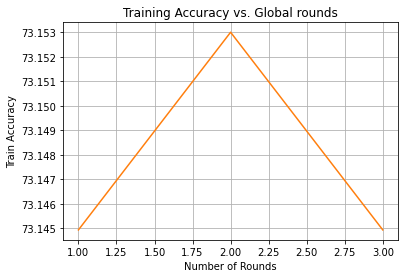

In [ ]:
# number of training rounds
rounds = 3
# client fraction
C = 0.5
# number of clients
K = 10
# number of training passes on local dataset for each round
E = 3
# batch size
batch_size = 10
# learning Rate
lr=1e-05
# dict containing different type of data partition
data_dict = iid_partition(training_set, 10)
d = {}
loss_function = torch.nn.CrossEntropyLoss()

if torch.cuda.is_available():
  model.cuda()

bert_iid_trained, train_acc = training(model, rounds, train_dataset, data_dict, loss_function, lr, C, K, E, "orange")

In [ ]:
def calcuate_accuracy(big_idx, targets):
  n_correct = (big_idx==targets).sum().item()
  return n_correct

In [ ]:
#Testing the trained model

def valid(model, testing_loader, loss_function):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            #token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask)
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accuracy(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu


In [ ]:
import pickle

In [ ]:
print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

acc = valid(bert_iid_trained, testing_loader, loss_function)
print("Accuracy on test data = %0.2f%%" % acc)

d['train_acc'] = train_acc
d['test_acc'] = acc


with open(f'/content/drive/My Drive/DPFLALBERT_Dep_eps0_5.pkl', 'wb') as file:
  pickle.dump(d, file)

1it [00:00,  8.89it/s]

This is the validation section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch
Validation Loss per 100 steps: 0.801353931427002
Validation Accuracy per 100 steps: 50.0


310it [00:22, 13.50it/s]

Validation Loss Epoch: 0.6175447876414945
Validation Accuracy Epoch: 71.40549273021001
Accuracy on test data = 71.41%


/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:523: UserWarning: A ``sample_rate`` has been provided.Thus, the provided ``batch_size``and ``sample_size`` will be ignored.
  "A ``sample_rate`` has been provided."
/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:195: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full b

Training Loss per 5000 steps: 0.7259150147438049
Training Accuracy per 5000 steps: 37.5


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 1: 31.005248284214776
Training Loss Epoch: 0.7368929407288951
Training Accuracy Epoch: 31.005248284214776


1it [00:00,  3.71it/s]

Training Loss per 5000 steps: 0.778868556022644
Training Accuracy per 5000 steps: 12.5


310it [01:25,  3.63it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 2: 30.11707710940654
Training Loss Epoch: 0.7374415701435458
Training Accuracy Epoch: 30.11707710940654


1it [00:00,  3.69it/s]

Training Loss per 5000 steps: 0.7232372760772705
Training Accuracy per 5000 steps: 50.0


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 3: 30.15744852644328
Training Loss Epoch: 0.7371466521293887
Training Accuracy Epoch: 30.15744852644328


1it [00:00,  3.61it/s]

Training Loss per 5000 steps: 0.6542865037918091
Training Accuracy per 5000 steps: 50.0


310it [01:25,  3.63it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 1: 29.632620104965685
Training Loss Epoch: 0.7386578481043539
Training Accuracy Epoch: 29.632620104965685


1it [00:00,  3.70it/s]

Training Loss per 5000 steps: 0.7528366446495056
Training Accuracy per 5000 steps: 25.0


310it [01:25,  3.63it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 2: 30.278562777553493
Training Loss Epoch: 0.7371949103570754
Training Accuracy Epoch: 30.278562777553493


1it [00:00,  3.65it/s]

Training Loss per 5000 steps: 0.7289296388626099
Training Accuracy per 5000 steps: 37.5


310it [01:25,  3.63it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 3: 29.30964876867178
Training Loss Epoch: 0.7379899640237132
Training Accuracy Epoch: 29.30964876867178


1it [00:00,  3.66it/s]

Training Loss per 5000 steps: 0.7846379280090332
Training Accuracy per 5000 steps: 0.0


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 1: 29.55187727089221
Training Loss Epoch: 0.7381296703892369
Training Accuracy Epoch: 29.55187727089221


1it [00:00,  3.75it/s]

Training Loss per 5000 steps: 0.7586052417755127
Training Accuracy per 5000 steps: 25.0


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 2: 30.036334275333065
Training Loss Epoch: 0.736965948343277
Training Accuracy Epoch: 30.036334275333065


1it [00:00,  3.63it/s]

Training Loss per 5000 steps: 0.7768765687942505
Training Accuracy per 5000 steps: 25.0


310it [01:25,  3.63it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 3: 31.005248284214776
Training Loss Epoch: 0.7363879261478301
Training Accuracy Epoch: 31.005248284214776


1it [00:00,  3.64it/s]

Training Loss per 5000 steps: 0.7578685283660889
Training Accuracy per 5000 steps: 25.0


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 1: 30.197819943480017
Training Loss Epoch: 0.7379618158263545
Training Accuracy Epoch: 30.197819943480017


1it [00:00,  3.71it/s]

Training Loss per 5000 steps: 0.7267207503318787
Training Accuracy per 5000 steps: 25.0


310it [01:25,  3.63it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 2: 30.76301978199435
Training Loss Epoch: 0.7364211236276934
Training Accuracy Epoch: 30.76301978199435


1it [00:00,  3.71it/s]

Training Loss per 5000 steps: 0.7749479413032532
Training Accuracy per 5000 steps: 12.5


310it [01:24,  3.65it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 3: 30.803391199031086
Training Loss Epoch: 0.7369315751137272
Training Accuracy Epoch: 30.803391199031086


1it [00:00,  3.76it/s]

Training Loss per 5000 steps: 0.714235782623291
Training Accuracy per 5000 steps: 50.0


310it [01:25,  3.63it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 1: 31.166733952361728
Training Loss Epoch: 0.7368133817949603
Training Accuracy Epoch: 31.166733952361728


1it [00:00,  3.77it/s]

Training Loss per 5000 steps: 0.7634075880050659
Training Accuracy per 5000 steps: 12.5


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 2: 30.238191360516755
Training Loss Epoch: 0.7385817050933838
Training Accuracy Epoch: 30.238191360516755


1it [00:00,  3.73it/s]

Training Loss per 5000 steps: 0.7029312252998352
Training Accuracy per 5000 steps: 50.0


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 3: 30.15744852644328
Training Loss Epoch: 0.7362542679232936
Training Accuracy Epoch: 30.15744852644328
Round: 1... 	Average Loss: 0.737
Round: 1... 	Average Accuracy: 30.287


1it [00:00,  3.76it/s]

Training Loss per 5000 steps: 0.7336524724960327
Training Accuracy per 5000 steps: 37.5


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 1: 30.31893419459023
Training Loss Epoch: 0.7362084496405816
Training Accuracy Epoch: 30.31893419459023


1it [00:00,  3.78it/s]

Training Loss per 5000 steps: 0.7418780326843262
Training Accuracy per 5000 steps: 25.0


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 2: 31.166733952361728
Training Loss Epoch: 0.737465549092139
Training Accuracy Epoch: 31.166733952361728


1it [00:00,  3.70it/s]

Training Loss per 5000 steps: 0.6980931162834167
Training Accuracy per 5000 steps: 37.5


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 3: 30.15744852644328
Training Loss Epoch: 0.7367040634155273
Training Accuracy Epoch: 30.15744852644328


1it [00:00,  3.73it/s]

Training Loss per 5000 steps: 0.7317876815795898
Training Accuracy per 5000 steps: 25.0


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 1: 29.7537343560759
Training Loss Epoch: 0.7361845377952821
Training Accuracy Epoch: 29.7537343560759


1it [00:00,  3.80it/s]

Training Loss per 5000 steps: 0.7050455808639526
Training Accuracy per 5000 steps: 50.0


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 2: 30.440048445700445
Training Loss Epoch: 0.7377736241586746
Training Accuracy Epoch: 30.440048445700445


1it [00:00,  3.75it/s]

Training Loss per 5000 steps: 0.7665836811065674
Training Accuracy per 5000 steps: 12.5


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 3: 31.207105369398466
Training Loss Epoch: 0.7365033449665193
Training Accuracy Epoch: 31.207105369398466


1it [00:00,  3.72it/s]

Training Loss per 5000 steps: 0.751865029335022
Training Accuracy per 5000 steps: 37.5


310it [01:25,  3.63it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 1: 30.682276947920872
Training Loss Epoch: 0.735865371265719
Training Accuracy Epoch: 30.682276947920872


1it [00:00,  3.68it/s]

Training Loss per 5000 steps: 0.783675491809845
Training Accuracy per 5000 steps: 12.5


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 2: 30.197819943480017
Training Loss Epoch: 0.7369487018354477
Training Accuracy Epoch: 30.197819943480017


1it [00:00,  3.80it/s]

Training Loss per 5000 steps: 0.7362558841705322
Training Accuracy per 5000 steps: 37.5


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 3: 29.874848607186113
Training Loss Epoch: 0.7380309145296774
Training Accuracy Epoch: 29.874848607186113


1it [00:00,  3.76it/s]

Training Loss per 5000 steps: 0.7229701280593872
Training Accuracy per 5000 steps: 25.0


310it [01:25,  3.65it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 1: 29.430763019781995
Training Loss Epoch: 0.7366443643646855
Training Accuracy Epoch: 29.430763019781995


1it [00:00,  3.86it/s]

Training Loss per 5000 steps: 0.7315409183502197
Training Accuracy per 5000 steps: 37.5


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 2: 30.56116269681066
Training Loss Epoch: 0.7380654402317539
Training Accuracy Epoch: 30.56116269681066


1it [00:00,  3.77it/s]

Training Loss per 5000 steps: 0.7332168221473694
Training Accuracy per 5000 steps: 25.0


310it [01:25,  3.65it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 3: 30.52079127977392
Training Loss Epoch: 0.7363466030166995
Training Accuracy Epoch: 30.52079127977392


1it [00:00,  3.77it/s]

Training Loss per 5000 steps: 0.798946738243103
Training Accuracy per 5000 steps: 12.5


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 1: 30.641905530884134
Training Loss Epoch: 0.7346197384019052
Training Accuracy Epoch: 30.641905530884134


1it [00:00,  3.72it/s]

Training Loss per 5000 steps: 0.6912280321121216
Training Accuracy per 5000 steps: 37.5


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 2: 30.15744852644328
Training Loss Epoch: 0.7374591427464638
Training Accuracy Epoch: 30.15744852644328


1it [00:00,  3.80it/s]

Training Loss per 5000 steps: 0.7169172763824463
Training Accuracy per 5000 steps: 25.0


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 3: 30.964876867178038
Training Loss Epoch: 0.7366842241056504
Training Accuracy Epoch: 30.964876867178038
Round: 2... 	Average Loss: 0.737
Round: 2... 	Average Accuracy: 30.545


1it [00:00,  3.79it/s]

Training Loss per 5000 steps: 0.7415284514427185
Training Accuracy per 5000 steps: 0.0


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 1: 30.884134033104562
Training Loss Epoch: 0.7358292706551091
Training Accuracy Epoch: 30.884134033104562


1it [00:00,  3.73it/s]

Training Loss per 5000 steps: 0.745255172252655
Training Accuracy per 5000 steps: 25.0


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 2: 30.601534113847396
Training Loss Epoch: 0.7364031958964563
Training Accuracy Epoch: 30.601534113847396


1it [00:00,  3.72it/s]

Training Loss per 5000 steps: 0.7863683700561523
Training Accuracy per 5000 steps: 12.5


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 3: 29.471134436818733
Training Loss Epoch: 0.736509241596345
Training Accuracy Epoch: 29.471134436818733


1it [00:00,  3.77it/s]

Training Loss per 5000 steps: 0.7248131036758423
Training Accuracy per 5000 steps: 25.0


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 1: 30.197819943480017
Training Loss Epoch: 0.7353573560714721
Training Accuracy Epoch: 30.197819943480017


1it [00:00,  3.74it/s]

Training Loss per 5000 steps: 0.7315038442611694
Training Accuracy per 5000 steps: 25.0


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 2: 31.045619701251514
Training Loss Epoch: 0.735545160501234
Training Accuracy Epoch: 31.045619701251514


1it [00:00,  3.77it/s]

Training Loss per 5000 steps: 0.734900712966919
Training Accuracy per 5000 steps: 0.0


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 3: 30.72264836495761
Training Loss Epoch: 0.7377113138475726
Training Accuracy Epoch: 30.72264836495761


1it [00:00,  3.79it/s]

Training Loss per 5000 steps: 0.6842734217643738
Training Accuracy per 5000 steps: 50.0


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 1: 30.480419862737183
Training Loss Epoch: 0.7365362515372614
Training Accuracy Epoch: 30.480419862737183


1it [00:00,  3.78it/s]

Training Loss per 5000 steps: 0.7473923563957214
Training Accuracy per 5000 steps: 37.5


310it [01:25,  3.63it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 2: 30.56116269681066
Training Loss Epoch: 0.7364589919967036
Training Accuracy Epoch: 30.56116269681066


1it [00:00,  3.83it/s]

Training Loss per 5000 steps: 0.7601798176765442
Training Accuracy per 5000 steps: 12.5


310it [01:25,  3.63it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 3: 30.399677028663707
Training Loss Epoch: 0.7370324888537007
Training Accuracy Epoch: 30.399677028663707


1it [00:00,  3.75it/s]

Training Loss per 5000 steps: 0.751007080078125
Training Accuracy per 5000 steps: 25.0


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 1: 30.9245054501413
Training Loss Epoch: 0.7357388825185838
Training Accuracy Epoch: 30.9245054501413


1it [00:00,  3.78it/s]

Training Loss per 5000 steps: 0.7722361087799072
Training Accuracy per 5000 steps: 12.5


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 2: 30.52079127977392
Training Loss Epoch: 0.73608440391479
Training Accuracy Epoch: 30.52079127977392


1it [00:00,  3.80it/s]

Training Loss per 5000 steps: 0.7385095953941345
Training Accuracy per 5000 steps: 37.5


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 3: 30.682276947920872
Training Loss Epoch: 0.7365018419681056
Training Accuracy Epoch: 30.682276947920872


1it [00:00,  3.76it/s]

Training Loss per 5000 steps: 0.7317200303077698
Training Accuracy per 5000 steps: 25.0


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 1: 29.7537343560759
Training Loss Epoch: 0.7361692653548333
Training Accuracy Epoch: 29.7537343560759


1it [00:00,  3.77it/s]

Training Loss per 5000 steps: 0.7187443375587463
Training Accuracy per 5000 steps: 25.0


310it [01:25,  3.64it/s]
0it [00:00, ?it/s]

The Total Accuracy for Epoch 2: 29.874848607186113
Training Loss Epoch: 0.7370857173396695
Training Accuracy Epoch: 29.874848607186113


1it [00:00,  3.67it/s]

Training Loss per 5000 steps: 0.7127504944801331
Training Accuracy per 5000 steps: 25.0


310it [01:25,  3.63it/s]


The Total Accuracy for Epoch 3: 31.53007670569237
Training Loss Epoch: 0.7361879283382047
Training Accuracy Epoch: 31.53007670569237
Round: 3... 	Average Loss: 0.737
Round: 3... 	Average Accuracy: 30.561
Training Done!
Total time taken to Train: 3835.130675792694


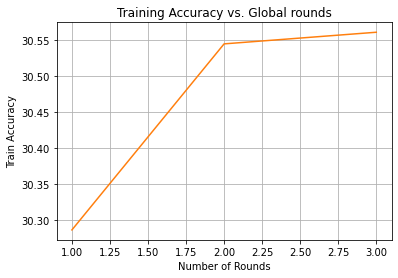

In [ ]:
# number of training rounds
rounds = 3
# client fraction
C = 0.5
# number of clients
K = 10
# number of training passes on local dataset for each round
E = 3
# batch size
batch_size = 10
# learning Rate
lr=1e-05
# dict containing different type of data partition
data_dict = non_iid_partition(training_set, 10, 240, 10, 10)
#iid_partition(training_set, 10)
d={}
loss_function = torch.nn.CrossEntropyLoss()

if torch.cuda.is_available():
  model.cuda()

bert_non_iid_trained, train_acc = training(model, rounds, train_dataset, data_dict, loss_function, lr, C, K, E, "orange")

In [ ]:
print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

acc = valid(bert_non_iid_trained, testing_loader, loss_function)
print("Accuracy on test data = %0.2f%%" % acc)


d['train_acc'] = train_acc
d['test_acc'] = acc


with open(f'/content/drive/My Drive/DPFLALBERT_Dep_eps0_5_noniid.pkl', 'wb') as file:
  pickle.dump(d, file)

2it [00:00, 11.96it/s]

This is the validation section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch
Validation Loss per 100 steps: 0.6576423048973083
Validation Accuracy per 100 steps: 50.0


310it [00:23, 13.33it/s]

Validation Loss Epoch: 0.73312256893804
Validation Accuracy Epoch: 31.34087237479806
Accuracy on test data = 31.34%
